In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import os
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [3]:
play('./violence/Real Life Violence Dataset\Violence/V_314.mp4')

In [4]:
play('./violence/Real Life Violence Dataset/NonViolence/NV_275.mp4')

In [5]:
import tensorflow as tf
import cv2
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 96
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        fps = vidcap.get(1)
        ret, image = vidcap.read()
        
        #6프레임마다 이미지 증강, BGR채널을 RGB로, 리사이징
        if ret:
            if (fps % 6 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.2)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-30, 30))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
        
    vidcap.release()
    
    return ImageFrames

In [6]:
%%time
from tqdm import tqdm

VideoDataDir = './violence/Real Life Violence Dataset'
print('Violence videos : {}  \nNonViolence videos : {}'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X = []
y = []

CLASSES = ["NonViolence", "Violence"]

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:370])): #메모리 문제로 1000개 영상 중 370개씩 추림
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X.append(frame)
            y.append(class_num)


Violence videos : 1000  
NonViolence videos : 1000


100%|██████████| 370/370 [03:12<00:00,  1.92it/s]

CPU times: total: 13min
Wall time: 4min 51s


In [7]:
import numpy as np
X = np.array(X).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y = np.array(y)

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

for train_index, test_index in stratified_sample.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [11]:
#훈련, 검증, 시험 데이터 크기 확인
X_train.shape, X_val.shape, X_test.shape

((10787, 96, 96, 3), (2697, 96, 96, 3), (3372, 96, 96, 3))

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dropout,Flatten,Dense


In [14]:
from keras import regularizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

#kernel_regularizer = regularizers.l2(0.0001)

def model_mobile():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg', include_top=False, input_tensor=input_tensor)
    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for layer in baseModel.layers:
        layer.trainable = False
        
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return model

In [15]:
model = model_mobile()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [16]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(patience = 5, monitor='val_loss', mode='min', restore_best_weights=True, verbose = 1)
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min', min_delta=0.0001)

epochs = 100                              
batch_size = 8

log_dir="./logs/fit/"
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min',
                                        verbose = 1, save_best_only=True)

callbacks = [model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

In [17]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train ,y_train, epochs=epochs, callbacks=callbacks, validation_data = (X_val, y_val),
                        batch_size=batch_size)

model.load_weights(checkpoint_filepath)

c:\ProgramData\Anaconda3\envs\proj4\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
1349/1349 [==============================] - ETA: 0s - loss: 0.2985 - accuracy: 0.8761
Epoch 00001: val_loss improved from inf to 0.21262, saving model to ModelWeights.h5
1349/1349 [==============================] - 45s 27ms/step - loss: 0.2985 - accuracy: 0.8761 - val_loss: 0.2126 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 2/100
1348/1349 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9318
Epoch 00002: val_loss improved from 0.21262 to 0.20307, saving model to ModelWeights.h5
1349/1349 [==============================] - 35s 26ms/step - loss: 0.1799 - accuracy: 0.9318 - val_loss: 0.2031 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 3/100
1349/1349 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9412
Epoch 00003: val_loss did not improve from 0.20307
1349/1349 [==============================] - 34s 26ms/step - loss: 0.1539 - accuracy: 0.9412 - val_loss: 0.2226 - val_accuracy: 0.9132 - lr: 0.0010
Epoch 4/100
1349/1349 [=============

In [27]:
history.history.items()

dict_items([('loss', [0.29852014780044556, 0.17994415760040283, 0.1539294570684433, 0.13938283920288086, 0.12515294551849365, 0.11815501004457474, 0.11469220370054245, 0.08988053351640701, 0.08670052140951157, 0.08601760864257812, 0.08533599227666855, 0.08466056734323502, 0.0840153843164444, 0.08153825253248215, 0.08122742176055908, 0.08119126409292221, 0.08083047717809677, 0.08082332462072372, 0.08079111576080322]), ('accuracy', [0.8761472105979919, 0.9317697286605835, 0.941225528717041, 0.9460461735725403, 0.9535552263259888, 0.9555019736289978, 0.958746612071991, 0.968295156955719, 0.9703346490859985, 0.9713544249534607, 0.9701492786407471, 0.9708908796310425, 0.9715397953987122, 0.9733939170837402, 0.9736720323562622, 0.9740428328514099, 0.9741355180740356, 0.9743209481239319, 0.9745063781738281]), ('val_loss', [0.21261733770370483, 0.2030676305294037, 0.22255250811576843, 0.1803474873304367, 0.1734466254711151, 0.1744183450937271, 0.17823727428913116, 0.16922049224376678, 0.168921

In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

106/106 [==============================] - 3s 33ms/step - loss: 0.1546 - accuracy: 0.9395


In [31]:
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    val_values = history.history['val_' + item][0:index]
    plt.plot(val_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()


In [33]:
def model_summary(model, history):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    if history:
        index = 14
        print('Best Epochs: ', index)

        train_acc = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_acc,'\tLoss on train:',train_loss)
        print('Accuracy on valid:',test_acc,'\tLoss on valid:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)  

Best Epochs:  14
Accuracy on train: 0.9736720323562622 	Loss on train: 0.08122742176055908
Accuracy on test: 0.9395017623901367 	Loss on test: 0.15463373064994812


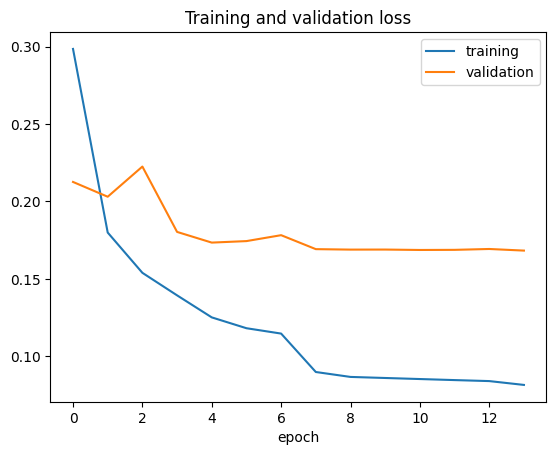

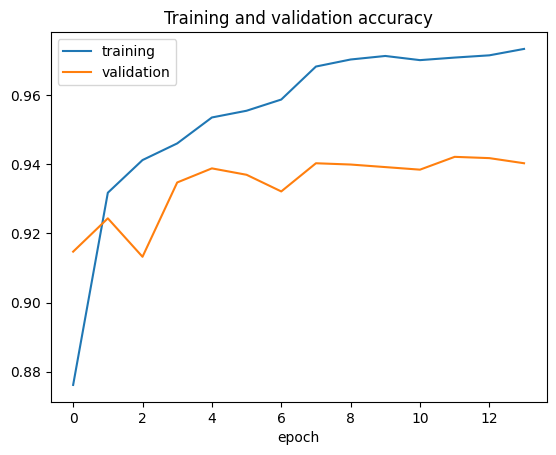

In [34]:
model_summary(model, history)
#test -> valid로 수정하였으나 재실행하지 못함;

In [35]:
print("Evaluating network...")
predictions = model.predict(X_test)
preds = predictions > 0.5

Evaluating network...


> Correct Predictions: 3168
> Wrong Predictions: 204


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16736\3336970614.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16736\3336970614.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

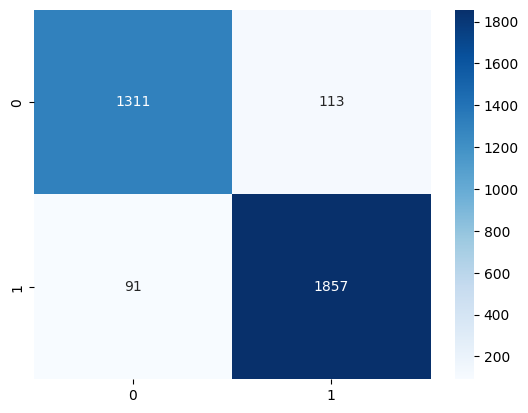

In [36]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

In [37]:
print(metrics.classification_report(y_test, preds, target_names=["NonViolence", "Violence"]))

              precision    recall  f1-score   support

 NonViolence       0.94      0.92      0.93      1424
    Violence       0.94      0.95      0.95      1948

    accuracy                           0.94      3372
   macro avg       0.94      0.94      0.94      3372
weighted avg       0.94      0.94      0.94      3372



In [38]:
model.save("violence.h5")

c:\ProgramData\Anaconda3\envs\proj4\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
